## Write a Data Science Blog Post
Author: Ashvin Srinivasan

Table of Contents:

- Introduction

- Business Understanding

-  Data Understanding 

-  Data Preparation

- Data Modelling 

- Evaluation

- Conclusion

### Introduction 

This blog spot is about the Seattle AirBNB data set. The following are the steps involved in data exploration. This blog spot has two requirements 

- A github post having all the data analysis/modelling.
- A post on Medium about the Seattle Airbnb dataset.

## Business Understanding

Airbnb is a company through which people could go about booking service apartments around the globe. There are different types of accommodations; independent house, apartments, wooden houses among others. 
Some of the business questions that we try to address:

1) What are the most common types of property types?

2) What are some of the top and bottom neighbourhoods based on mean average prices?

3) What are some of the best and less popular property types based on reveiwer ratings?

4) What are some of the top and bottom neighbourhoods based on reviewer ratings?

5) Which features are correlated with the reviewers ratings?

6) Build a predictive model, that would predict reviewers rating using chosen input features

## Data Understanding

The data have 3 files 
 - Calender.csv 
 - Listing.csv 
 - Reviews.csv

Listings, including full descriptions and average review score. Reviews, including unique id for each reviewer and detailed comments. Calendar, including listing id and the price and availability for that day


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
calDf = pd.read_csv('calendar.csv')
listDf = pd.read_csv('listings.csv')
revDf = pd.read_csv('reviews.csv')

In [3]:
#revcols = [col for col in listDf.columns.values if 'review' in col]

In [4]:
#df = listDf.dropna(subset = revcols, axis = 0)

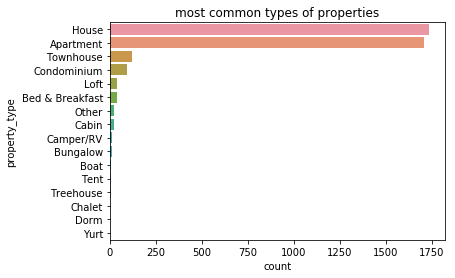

In [5]:
############### Get the most common types of property type #############

######## we see that most common types are House, Apartment while types like Yurt, Dorm are very minimal ########

ser = listDf['property_type'].value_counts()
serdf = pd.DataFrame(ser)
serdf.reset_index(inplace = True)
serdf.rename(columns = {'index':'property_type','property_type':'count'}, inplace = True)
ax1 = sns.barplot(y='property_type', x="count", data=serdf).set_title("most common types of properties")
#ax1 = plot(y ='property_type', x = 'count', data = serdf, titles = 'most common types of properties' )


In [6]:
def plot(subCols = None, grpbyCol = None, sort_val = None, y = None, x = None, data = listDf, titles = None):
    '''
    Input params: 
    y: column to be plotted on the y axis 
    x: column to be plotted on the x axis 
    data: contains the respective dataframe
    titles: title to be put on the graph 
    
    Returns: 
    Seaborn plot 
    '''
    df = data.dropna(subset = subCols, axis = 0)
    df.reset_index(inplace = True, drop = True)
    df['price'] = pd.Series([float(re.sub('[$,]', '', df.loc[i,'price'])) for i in range(len(df))])
    df1 = df.groupby(grpbyCol).mean()
    df1.sort_values(sort_val, inplace = True)
    df1.reset_index(inplace = True)
    df1 = pd.concat([df1.loc[0:4],df1.loc[len(df1)-5:len(df1)]], axis = 0)
    
    return sns.barplot(y=y, x=x, data=df1).set_title(titles)

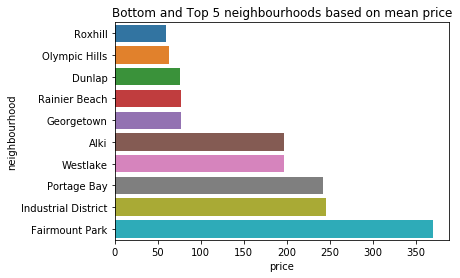

In [7]:
#### Calculate mean average price per neighbourhood ###########

####### neighbourhoods like Fairmserdfount park, Industrial District have average mean prices  in excess of 200 dollars while 
##### like Roxhill, Olympic Hills are in the range of 50 USD 

ax1 = plot(subCols = ['neighbourhood'],grpbyCol = 'neighbourhood',sort_val = 'price',y ='neighbourhood', x = 'price', data = listDf, titles = 'Bottom and Top 5 neighbourhoods based on mean price' )


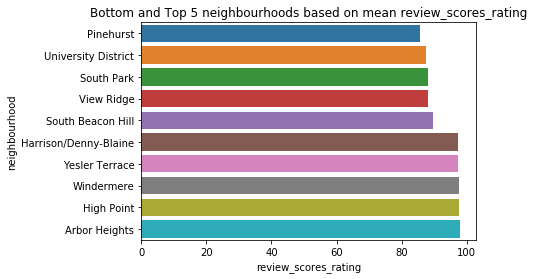

In [8]:
#### Calculate mean reviewer ratings per neighbourhood ###########

###### Negihbourhood such as Arbor Heights, High Points have higher mean review ratings as compared to Pinehurst and University District

ax1 = plot(subCols = ['neighbourhood','review_scores_rating'],grpbyCol = 'neighbourhood',sort_val = 'review_scores_rating' ,y ='neighbourhood', x = 'review_scores_rating', data = listDf, titles = 'Bottom and Top 5 neighbourhoods based on mean review_scores_rating' )


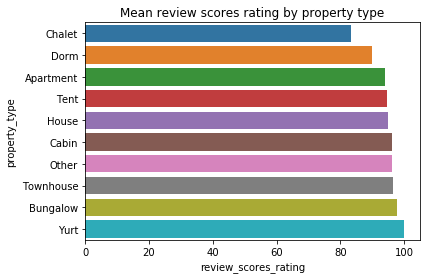

In [9]:
#### Calculate mean reviewer ratings by property type ###########
######### Property types like Chalet recieve lesser ratings as compared to apartments and houses types. 
ax1 = plot(subCols = ['property_type','review_scores_rating'], grpbyCol ='property_type',sort_val = 'review_scores_rating',y ='property_type', x = 'review_scores_rating', data = listDf, titles = 'Mean review scores rating by property type' )




In [10]:
############### Calculating occupancy rate ###############
########### assuming availability; t as to be filled, f as filled ##################
listCols = ['id','host_neighbourhood']
df = pd.merge(listDf[listCols], calDf, left_on = 'id', right_on = 'listing_id', how = 'inner')

df = df.dropna(subset = ['host_neighbourhood'], axis = 0)

In [11]:
m = ['t','f']
host_neigh = df['host_neighbourhood'].unique()
occupancy_rate = {}
for host in host_neigh:
    det = df[df['host_neighbourhood']==host]['available'].describe()
    occupancy_rate[host] = {det['top']:det['freq']/det['count'],list(set(m)-set(det['top']))[0]:(det['count']-det['freq'])/det['count']}
    #occupancy_rate[list(set(m)-set(det['top']))] = (det['count']-det['freq'])/det['count']
occDf = pd.DataFrame()
occDf['host_neighbourhood'] = pd.Series(list(occupancy_rate.keys()))
filled = []
for k in occupancy_rate.keys():
    filled.append(occupancy_rate[k]['f'])
occDf['filled'] = filled
occDf.sort_values('filled', inplace = True)
occDf.reset_index(inplace = True, drop = True)

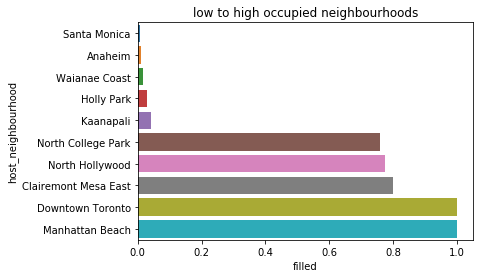

In [12]:
df1 = pd.concat([occDf.loc[6:10],occDf.loc[len(occDf)-5:len(occDf)]], axis = 0)
ax3 = sns.barplot(y='host_neighbourhood', x="filled", data=df1).set_title("low to high occupied neighbourhoods")


 The following features: *'experiences_offered','host_location',
          'host_response_time','host_response_rate','host_neighbourhood',
          'host_is_superhost','neighbourhood','property_type','square_feet', 
           'price','has_availability','review_scores_rating','review_scores_accuracy', 
           'review_scores_cleanliness','review_scores_location'* are chosen from rest of the other features as a first pass. 

Features like 'id', 'listing_url', 'scrape_id', 'last_scraped', 'name' have been dropped as they are unique and do not contribute much information to determine the reviwers rating. 

In [13]:
############### Building predicitive model ###################
########### Target variable is review_scores_rating ##########
###### input features chosen are: 
inpCols = ['experiences_offered','host_location',
          'host_response_time','host_response_rate','host_neighbourhood',
          'host_is_superhost','neighbourhood','property_type','square_feet', 
           'price','has_availability','review_scores_rating','review_scores_accuracy', 
           'review_scores_cleanliness','review_scores_location']


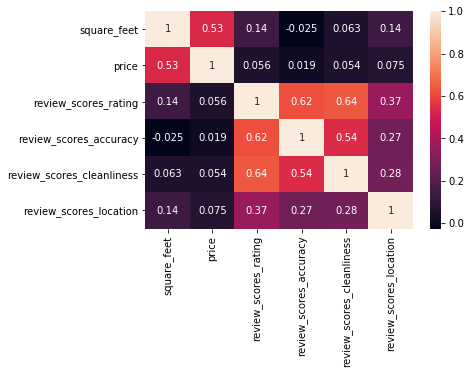

In [14]:
#### Plotting correlation between continous variables ########
df = listDf[inpCols]
df['price'] = pd.Series([float(re.sub('[$,]', '', df.loc[i,'price'])) for i in range(len(df))])
corr = df.corr()
ax = sns.heatmap(corr, annot=True)

In [15]:
############ Correlation between catgorical and target by ANOVA ###########
######### Find F score for categorical variables with <= 5 levels ###########
from scipy import stats

F1, p = stats.f_oneway(df[df['host_is_superhost'] == 'f']['review_scores_rating'],
                         df[df['host_is_superhost'] == 't']['review_scores_rating'])


F2, p = stats.f_oneway(df[df['host_response_time'] == 'within a few hours']['review_scores_rating'],
                       df[df['host_response_time'] == 'within an hour']['review_scores_rating'],
                       df[df['host_response_time'] == 'others']['review_scores_rating'],
                       df[df['host_response_time'] == 'within a day']['review_scores_rating'],
                       df[df['host_response_time'] == 'a few days or more']['review_scores_rating']
                       )


print('host_is_superhost F score:{}'.format(F1),'host_response_time F score:{}'.format(F2))


host_is_superhost F score:nan host_response_time F score:nan


Since Fscore for *host_response_time* is 13, deleting the feature won't affect much. Similarly dropping *price* feature based on the correlation value of 0.056 would be statistically a viable option

In [16]:
############ Build Pipeline #############
def pipeline(df):
    '''
    input: raw dataframe with missing values, unimportant columns
    
    Operations: Remove columns with single levels
                Find out the number of missing values in each column
                Dropping column with more 90% missing values
                Convert categorical into dummy variable 
                
    
    Returns: 
    a dataframe ready for modelling 
    
    '''
    
    ########## Removing columns with only a single level ################ 
    df.dropna(subset = ['review_scores_rating'], axis = 0, inplace = True)
    Cols = list(df.columns.values)
    catCols = []
    for col in df.columns.values:
        if str(df[col].dtypes) == 'object':
            if len(df[col].unique()) == 1:
                print('removing',col,'feature because its level is',len(df[col].unique()))
                Cols.remove(col)
    print('-------------------------------------------')
    df = df[Cols]
    
    ######## Determine number of missing NaN's ##########
    for col in df.columns.values:
        print(col,'has',round((sum(df[col].isnull())/len(df))*100,2),'% missing values')


    ############# Dropping out square_feet as missing impute is very high 97%  ######
    df.drop(columns = ['square_feet'], inplace = True)


    ####### Imputing missing values ########
    for col in df.columns.values:
        if str(df[col].dtypes) == 'object':
            df[col] = df[col].fillna("others")
        else:
            df[col].fillna((df[col].mean()), inplace=True)
            
   ################## Converting categorical variable into dummy #############################
    df.dtypes
    finalDf = pd.get_dummies(df)
    finalDf.drop(columns = ['price'], inplace = True)
    return finalDf

finalDf = pipeline(df)

removing experiences_offered feature because its level is 1
removing has_availability feature because its level is 1
-------------------------------------------
host_location has 0.0 % missing values
host_response_time has 9.84 % missing values
host_response_rate has 9.84 % missing values
host_neighbourhood has 6.4 % missing values
host_is_superhost has 0.0 % missing values
neighbourhood has 9.62 % missing values
property_type has 0.0 % missing values
square_feet has 97.13 % missing values
price has 0.0 % missing values
review_scores_rating has 0.0 % missing values
review_scores_accuracy has 0.35 % missing values
review_scores_cleanliness has 0.19 % missing values
review_scores_location has 0.25 % missing values


In [17]:
print('The total missing values is ',sum(finalDf.isnull().any()))

The total missing values is  0


## Data Modelling 

The data is finally prepared. Some of the operations performed were.
 
 -  Finding out correlated variables using ANOVA, correlation plots 
 -  Imputing missing values 
 - Converting categorical variables into dummy format 
 
After which we split the data into training and test data sets. Random Forest is used to model the algorithm. And we fit a model on the training data and obtain the subsequent training and testing mean squared errors. 

 

In [18]:
########### Preparing data set and splitting it into train and test data sets ##########
from sklearn.model_selection import train_test_split
X = finalDf.drop(columns = 'review_scores_rating')
y = finalDf['review_scores_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [19]:
########## Importing random forest regressor ################
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(min_samples_split=10,n_estimators=100)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
###### predicting for the test set ######
ypred = regr.predict(X_test)
ytrainpred = regr.predict(X_train)

## Data Evaluation

In [21]:
######## Calculate Mean square error ########
from sklearn.metrics import mean_squared_error
print("train set mean squared error:",mean_squared_error(y_train.values, ytrainpred),",test set mean squared error:",mean_squared_error(y_test.values, ypred))

train set mean squared error: 8.75471705729 ,test set mean squared error: 25.7032873879


## Conclusion 

AirBNB seattle dataset is explored. There are a total of three files, out of which listing file is the most used for exploration. The total listing ids are 3818 and there are a total of 92 features, out of which based on some statistical tests, certain features are selected. 

The Top observation are as follows

1) Most common property types are: 

            House              1733
            Apartment          1708
            Townhouse           118
            Condominium          91
            Loft                 40
            Bed & Breakfast      37
            Other                22
            Cabin                21
            Bungalow             13
            Camper/RV            13
            Boat                  8
            Tent                  5
            Treehouse             3
            Chalet                2
            Dorm                  2
            Yurt                  1

2) Most expensive neighbourhoods based on mean price
        
        Fairmount park
        Industrial district
        Portrage Bay 
        WestLake


3) Most popular property types
            
            Houses
            Loft
            Cabin 
            Tree
            Boat 
        while types like chalet, Dorm have relatively fewer ratings. 
        

4) Most popular neighbourhoods based on review ratings
        
          Arbour heights
          high points 
          windermere
         yesler terrace
         
5) We also built a predictive model after data preparation, imputing missing values and obtained a test MSE of 25.67          
        


## Licences

Airbnb dataset for seattle was used which is publicly available and published by AirBNB

Python packages seaborn was used for visualization 

## References

- Medium 

- Kaggle 

- Stack Overfllow